In [2]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from keras.layers import Dropout
from sklearn import metrics
import re
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

In [4]:
# Preparation of generation data
generation_data = pd.read_excel('generation.xlsx', names=['Timestamp', 'Column_2', 'Active_energy', 'Column_4', 'Column_5']) # read the data
generation_data = generation_data.drop(['Column_2', 'Column_4', 'Column_5'], axis=1) # drop extra data
generation_data = generation_data.drop([66238, 66239]) # drop last two rows, because they are sum of each column
generation_data.Timestamp = pd.to_datetime(generation_data.Timestamp, format='mixed', errors='raise') 
generation_data.Active_energy = pd.to_numeric(generation_data.Active_energy, errors='coerce') 
generation_data['Pgen'] = generation_data.Active_energy / 0.05 / 1000 # add the column generated power from energy
generation_data = generation_data.dropna() # there are just each third value of Active energy, other rows are droped
generation_data = generation_data.drop(['Active_energy'], axis=1) # active_energy is useless

In [48]:
# Preparation of insolation data
insolation_data = pd.read_excel('insolation.xlsx', names=['Timestamp', 'Insolation'])
insolation_data = insolation_data.drop([66240, 66241]) # drop last two rows, because they are sum of each column
insolation_data.Timestamp = pd.to_datetime(insolation_data.Timestamp, format='mixed', errors='raise')
clear_function = lambda x: re.findall(r'[-]?\d+[.,]?\d{0,}', str(x))[0] if len(re.findall(r'[-]?\d+[.,]?\d{0,}', str(x)))>0 else None
insolation_data.Insolation = insolation_data.Insolation.apply(clear_function) # there are valueses in wrong format
# insolation_data.loc[insolation_data.Insolation.isna()]
insolation_data = insolation_data.dropna() # drop None (-) values
insolation_data.Insolation = pd.to_numeric(insolation_data.Insolation)
insolation_data.Insolation = insolation_data.Insolation.apply(lambda x: 0 if x<0 else x) # all negative values are accepted as null
# insolation_data.describe()

In [50]:
# data merging
data = generation_data.merge(insolation_data, how='inner', on='Timestamp') # отсувствую данные по инсоляции с 19.10 по 28.10; 4439 среза
data = data.drop('Timestamp', axis=1)

Добавление производной по инсоляции не приносит улучшений

In [738]:
# feature engineering
# Add to data feature Wind_speed_change_velocity which shows difference wind speed at the moment and wind speed at the previous moment
insolation_velocity = []
insolation = data.Insolation
for index in data.index:
    velocity = insolation.iloc[index] - insolation.iloc[index-1]
    insolation_velocity.append(velocity)
data['Insolation_velocity'] = pd.DataFrame(insolation_velocity)#, columns= ["Wind_speed_change_velocity"])
# pd.DataFrame(wind_speed_velocity, columns= ["Wind_speed_change_velocity"])
# data['Insolation_velocity'] = 
data[2200:2400]

,Pgen,Insolation,Insolation_velocity
2200,9.8448,556.0921,-64.6179
2201,11.8944,646.5082,90.4161
2202,12.1128,684.2356,37.7274
2203,11.9112,674.7910,-9.4446
2204,10.6680,652.4321,-22.3589
...,...,...,...
2395,0.0000,0.0000,0.0000
2396,0.0000,0.0000,0.0000
2397,0.0000,0.0000,0.0000
2398,0.0000,0.0000,0.0000


## Create MLP

In [132]:
# Разделение данных на обучающую и тестовую выборки
y = data.Pgen#.to_numpy()
# y = np.asarray(y, dtype=float)
X = data.drop('Pgen', axis=1)#.to_numpy()
#X = np.asarray(X, dtype=float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X.shape[1] #control number of features

# Нормализация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
def MLP_creater (first_hidden_layer_neurons, second_hidden_layer_neurons, first_hidden_layer_activation = 'tanh', second_hidden_layer_activation = 'relu', dropout=0.2, 
                 input_dim=n_features, loss='mae', optimizer='adam'):
    # Создание модели MLP
    model = Sequential()
    model.add(Dense(first_hidden_layer_neurons, input_dim = n_features, activation=first_hidden_layer_activation)) # Первый скрытый слой
    model.add(Dense(second_hidden_layer_neurons, activation=second_hidden_layer_activation)) # Второй скрытый слой
    model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1)) # Выходной слой (регрессия)
    
    # Компиляция модели
    model.compile(optimizer=optimizer, loss=loss)#, metrics=['mse'])
    return model

In [176]:
model_MLP = MLP_creater(300,300,dropout=0.4, first_hidden_layer_activation='relu', loss='mae')
history = model_MLP.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/4


C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9113 - val_loss: 0.2079
Epoch 2/4
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2618 - val_loss: 0.2066
Epoch 3/4
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2672 - val_loss: 0.2038
Epoch 4/4
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2613 - val_loss: 0.2055


In [177]:
# Метрики на всей тестовой выборке
y_pred_MLP = model_MLP.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred_MLP)
# mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred_MLP)
print(f"""MAE is {mae} 
MSE is {mse}""")

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
MAE is 0.20552394103300697 
MSE is 0.3170776633830981


In [182]:
# Оценка модели на интервале
train_size = int(len(X) * 0.8)
X_same_as_lstm = X[train_size:]
y_same_as_lstm = y[train_size:]
min_interval = 3250 #2200
max_interval = 3350 #2400
X_interval = scaler.transform(X_same_as_lstm[min_interval:max_interval])
y_pred_MLP = model_MLP.predict(X_interval)
y_interval = y_same_as_lstm[min_interval:max_interval].reset_index(drop=True)
mae = metrics.mean_absolute_error(y_interval, y_pred_MLP)
print(f"Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.20301603949356084


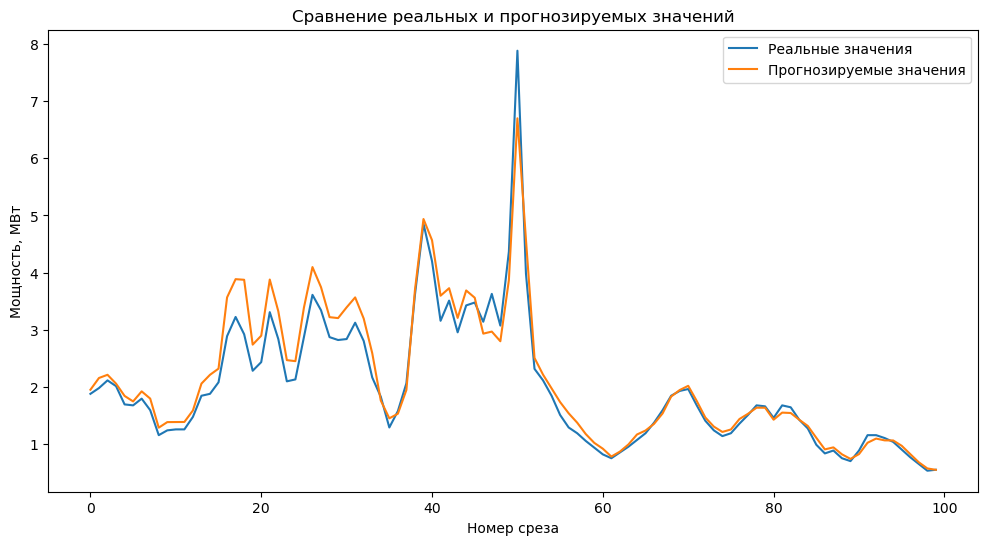

In [184]:
# Визуализация результатов
plt.figure(figsize=(12,6))
plt.plot(y_interval, label='Реальные значения')
plt.plot(y_pred_MLP, label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

## Create LSTM model

In [70]:
# Подготовка данных для LSTM
def prepare_data(series, look_back=4):
    """
    Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back
    В результает метод возвращает массив Х и у
    """
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series.iloc[i:i + look_back])  # Входные данные (последовательность)
        y.append(series.iloc[i + look_back, 0])  # Целевое значение (прогнозируем первый признак)
    return np.array(X), np.array(y)

# NN creating
def create_LSTM_model(n_features, LSTM_units=120, actication='relu', look_back=4, loss='mae', dropout=None, optimizer='adam'):
    """
    В методе собраны все шаги по построение LSTM. Возвращает скомпилированную модель
    """
    model = Sequential()
    model.add(LSTM(LSTM_units, activation='relu', input_shape=(look_back, n_features)))  # LSTM слой с 50 нейронами
    if dropout != None:
        model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1))  # Выходной слой для прогнозирования одного значения
    # model compilating
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])  # Оптимизатор Adam и функция потерь MAE
    return model

def data_split_and_scaler(data, look_back=4, train_size_=0.8):
    """
    Метод разбивает получет данные data. В данных первый столбец - прогнозируемый признак.\n Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back.
    Затем данные маштабируются и формируются test и train массивы с заданной величиной тренировочного массива train_size_.\n Также метод возращает scaler для дальнейшего обратного преобразования.
    """
    X, y = prepare_data(data, look_back) # makes from data X and y arrays
    n_features = len(data.columns) #calculate count of features

    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape[0], look_back, n_features)
    y = scaler.fit_transform(y.reshape(-1, 1))

    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(X) * train_size_)
    X_train, X_test = X[:train_size], X[train_size:] # данные должны бть последовательными, поэтому делю так
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [124]:
n_features = len(data.columns)
X_train, X_test, y_train, y_test, scaler = data_split_and_scaler(data, look_back=1, train_size_=0.8)
model_LSTM = create_LSTM_model(n_features=n_features, LSTM_units=120, actication='relu', look_back=1, loss='mae', dropout=0.0, optimizer='adam')

C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [125]:
# Обучение модели
history = model_LSTM.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), verbose=1)

Epoch 1/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0677 - mse: 0.0306 - val_loss: 0.0075 - val_mse: 4.3305e-04
Epoch 2/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - mse: 0.0027 - val_loss: 0.0065 - val_mse: 3.6513e-04
Epoch 3/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0149 - mse: 0.0025 - val_loss: 0.0072 - val_mse: 3.5949e-04
Epoch 4/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0136 - mse: 0.0021 - val_loss: 0.0067 - val_mse: 3.6634e-04
Epoch 5/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148 - mse: 0.0026 - val_loss: 0.0070 - val_mse: 3.6889e-04
Epoch 6/6
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0142 - mse: 0.0025 - val_loss: 0.0059 - val_mse: 3.6248e-04


In [127]:
# Прогнозирование на тестовых данных
y_pred_LSTM = model_LSTM.predict(X_test)

# Обратное масштабирование данных для сравнения с реальными значениями
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred_LSTM)
mae = metrics.mean_absolute_error(y_test_original, y_pred_original)
mae

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   


0.07691535094520185

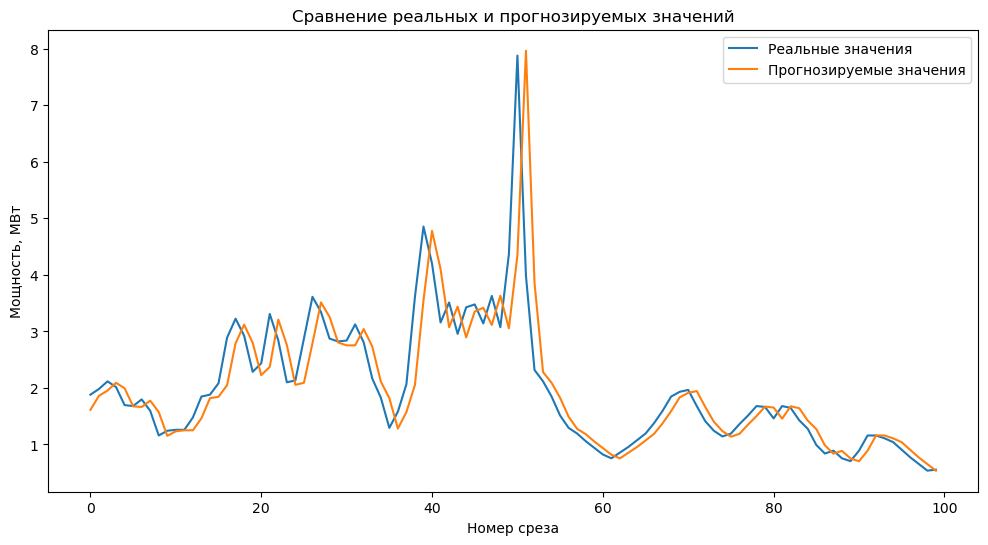

In [130]:
# Визуализация результатов
plt.figure(figsize=(12,6))
plt.plot(y_test_original[3250:3350], label='Реальные значения',)
plt.plot(y_pred_original[3250:3350], label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

## Visualisation of generation and insolation dependency using URFU data

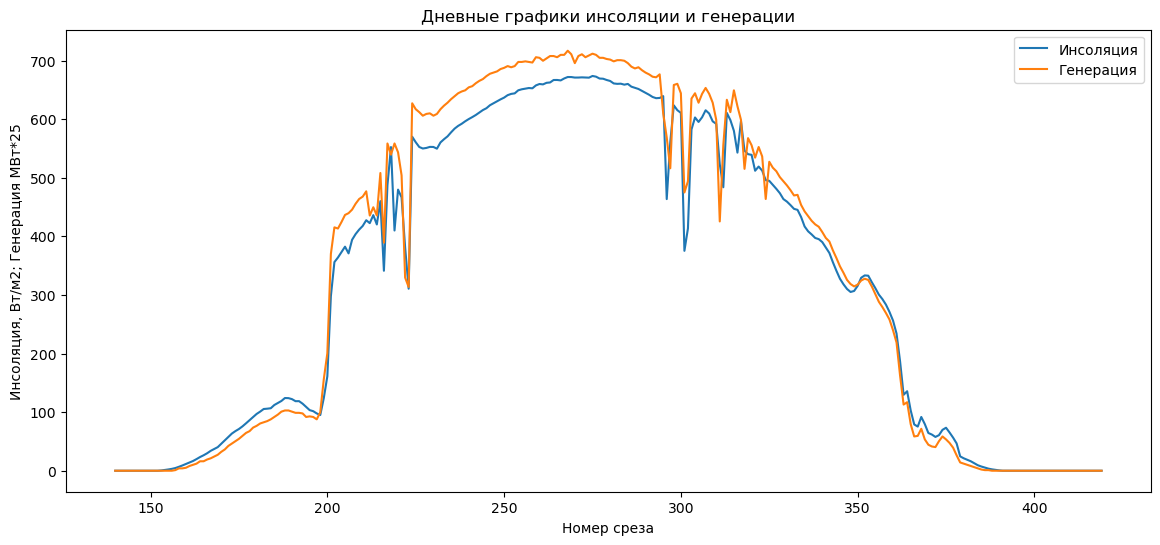

In [297]:
# Визуализация результатов на интервале
plt.figure(figsize=(14, 6))
plt.plot(data.Insolation[140:420], label='Инсоляция')
plt.plot(data.Pgen[140:420]*60, label='Генерация')
plt.title('Дневные графики инсоляции и генерации')
plt.xlabel('Номер среза')
plt.ylabel('Инсоляция, Вт/м2; Генерация МВт*25')
plt.legend()
plt.show()